# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [ ]:
!pip install pymongo

In [ ]:
!pip install pymongo[srv]

In [ ]:
!pip install dnspython

In [ ]:
!pip install tweepy

In [ ]:
!pip install twitter

## Import Python libraries

In [1]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secret']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_token_secret']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [3]:
client = MongoClient(mongod_connect)
db = client.gp9 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [ ]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [ ]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [4]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [5]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5222654,-77.5818607,150mi"  # defin the location, in Harrisonburg, VA
q = "COVID-19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [6]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Sun Nov 22 01:02:29 +0000 2020'
'Sun Nov 22 01:02:25 +0000 2020'
'Sun Nov 22 01:02:21 +0000 2020'
'Sun Nov 22 01:02:16 +0000 2020'
'Sun Nov 22 01:02:09 +0000 2020'
'Sun Nov 22 01:02:01 +0000 2020'
'Sun Nov 22 01:01:59 +0000 2020'
'Sun Nov 22 01:01:58 +0000 2020'
'Sun Nov 22 01:01:55 +0000 2020'
'Sun Nov 22 01:01:54 +0000 2020'
'Sun Nov 22 01:01:51 +0000 2020'
'Sun Nov 22 01:01:47 +0000 2020'
'Sun Nov 22 01:01:47 +0000 2020'
'Sun Nov 22 01:01:41 +0000 2020'
'Sun Nov 22 01:01:40 +0000 2020'
'Sun Nov 22 01:01:37 +0000 2020'
'Sun Nov 22 01:01:36 +0000 2020'
'Sun Nov 22 01:01:34 +0000 2020'
'Sun Nov 22 01:01:31 +0000 2020'
'Sun Nov 22 01:01:26 +0000 2020'
'Sun Nov 22 01:01:25 +0000 2020'
'Sun Nov 22 01:01:19 +0000 2020'
'Sun Nov 22 01:01:15 +0000 2020'
'Sun Nov 22 01:01:08 +0000 2020'
'Sun Nov 22 01:01:05 +0000 2020'
'Sun Nov 22 01:01:02 +0000 2020'
'Sun Nov 22 01:01:00 +0000 2020'
'Sun Nov 22 01:00:58 +0000 2020'
'Sun Nov 22 01:00:56 +0000 2020'
'Sun Nov 22 01:00:54 +0000 2020'
'Sun Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [7]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Sat Nov 21 20:48:45 +0000 2020'


KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [8]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

9705
8788


Create a text index and print the Tweets containing specific keywords. 

In [9]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [10]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid"}}) # return tweets contain vote

Use pprint to display tweets

In [11]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: WestSide 🌊
text: @DevinCow Don't turn my COVID 19 into COVID 20 lbs.
----
name: ADAPs
text: COVID-19 is Exacerbating Existing Epidemics https://t.co/VHMJFq9Tdz #HIV #COVID
----
name: Aquarius of Age
text: @nypmetro They think they're tired of covid-19, but covid-19 is just getting started with them. 😬🥴
----
name: Lleni
text: RT @AnthonyLeeVoice: @JoyAnnReid Sadly, the COVID-19 pandemic is both an IQ test (understanding that COVID is real and taking precautions)…
----
name: unapologetic badass
text: Apparently my county is doing so bad with COVID-19 , but most of our hospitals have zero covid patients at this tim… https://t.co/qluWfse9zx
----
name: Beryl Harvey
text: RT @AnthonyLeeVoice: @Sky_Lee_1 @DebraMessing Sadly, the COVID-19 pandemic is both an IQ test (understanding that COVID is real and taking…
----
name: Ms. LaGuerre
text: RT @AnthonyLeeVoice: @Sky_Lee_1 @DebraMessing Sadly, the COVID-19 pandemic is both an IQ test (understanding that COVID is real and taking…
----

In [13]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid"}}) # return tweets contain vote

Use pandas to display tweets

In [14]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,possibly_sensitive,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,5fb9b7e0141783b3cebb3d38,Sat Nov 21 16:02:57 +0000 2020,1330179904281989123,1330179904281989123,@DevinCow Don't turn my COVID 19 into COVID 20...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.330029e+18,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,5fb9b7be141783b3cebb2fbe,Sat Nov 21 18:05:09 +0000 2020,1330210657258573824,1330210657258573824,COVID-19 is Exacerbating Existing Epidemics ht...,False,"{'hashtags': [{'text': 'HIV', 'indices': [68, ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,...,0,False,False,en,False,NaN,NaN,NaN,NaN,NaN
2,5fb9b78b141783b3cebb1c7e,Sat Nov 21 23:09:19 +0000 2020,1330287201876402179,1330287201876402179,@nypmetro They think they're tired of covid-19...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.330242e+18,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
3,5fb9b7b7141783b3cebb2d26,Sat Nov 21 18:42:55 +0000 2020,1330220162923061250,1330220162923061250,"RT @AnthonyLeeVoice: @JoyAnnReid Sadly, the CO...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,NaN,{'created_at': 'Sat Nov 21 05:23:33 +0000 2020...,NaN,NaN,NaN,NaN
4,5fb9b7b7141783b3cebb2d24,Sat Nov 21 18:43:05 +0000 2020,1330220203117072384,1330220203117072384,Apparently my county is doing so bad with COVI...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,12,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
5,5fb9b796141783b3cebb20ff,Sat Nov 21 21:51:16 +0000 2020,1330267562727395332,1330267562727395332,RT @AnthonyLeeVoice: @Sky_Lee_1 @DebraMessing ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,NaN,{'created_at': 'Sat Nov 21 20:38:43 +0000 2020...,NaN,NaN,NaN,NaN
6,5fb9b792141783b3cebb1f41,Sat Nov 21 22:16:49 +0000 2020,1330273992444358657,1330273992444358657,RT @AnthonyLeeVoice: @Sky_Lee_1 @DebraMessing ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,NaN,{'created_at': 'Sat Nov 21 20:38:43 +0000 2020...,NaN,NaN,NaN,NaN
7,5fb9b792141783b3cebb1f2d,Sat Nov 21 22:18:17 +0000 2020,1330274360683343877,1330274360683343877,RT @AnthonyLeeVoice: @Wonkette @MalcolmNance @...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,NaN,{'created_at': 'Sat Nov 21 21:47:35 +0000 2020...,NaN,NaN,NaN,NaN
8,5fb9b786141783b3cebb1ac0,Sat Nov 21 23:54:36 +0000 2020,1330298601399087105,1330298601399087105,"RT @AnthonyLeeVoice: @SethAbramson Sadly, the ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,NaN,{'created_at': 'Sat Nov 21 20:20:55 +0000 2020...,NaN,NaN,NaN,NaN
9,5fb9b782141783b3cebb1925,Sun Nov 22 00:33:15 +0000 2020,1330308324215189505,1330308324215189505,"RT @AnthonyLeeVoice: @SethAbramson Sadly, the ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're..

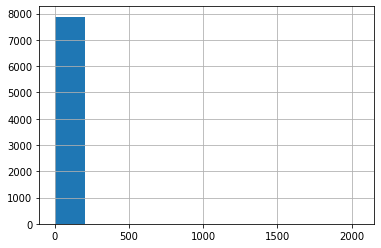

In [15]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count